In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn import metrics, model_selection

# Load the dataset
To start, you will train the basic autoencoder using the cifar10 dataset. Each image in this dataset is 32,32,3 pixels

In [ ]:
(x_train,_),(x_test,_) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)


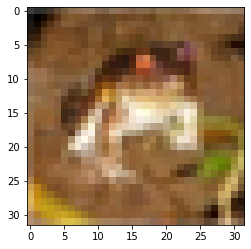

In [ ]:
plt.imshow(x_train[0])

# Create the Data Pipline with Adding Random Noise to the Images

While solving the problem statement, we have to remember our goal which is to make a model that is capable of performing noise removal on images. To be able to do this, we will use existing images and add them to random noise. Here we will feed the original images as input and we get the noisy images as output and our model (i.e, autoencoder) will learn the relationship between a clean image and a noisy image and learn how to clean a noisy image. So let’s create a noisy version of our fashion mnist dataset and give it as input to the decoder network.

In [ ]:
@tf.function
def normlizer(noise_images,images):

    # make sure the pixle values are between 0 and 1
    noise_images,images = noise_images/255,images/255
    return noise_images,images
@tf.function
def add_noise_to_image(noise_images,images):
    noise_factor = 0.1
    # add noise to the image
    noise_images = noise_images+noise_factor*tf.random.normal(shape= noise_images.shape)
    # clip the values to be between 0 and 1
    noise_images = tf.clip_by_value(noise_images,0.0,1.0)

    return noise_images, images


In [ ]:
test1_noise,test1 = normlizer(x_train[0],x_train[0])
test1_noise,test1= add_noise_to_image(test1_noise,test1)

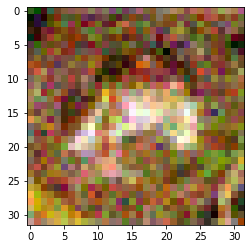

In [ ]:
plt.imshow(test1_noise)

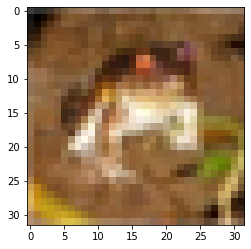

In [ ]:
plt.imshow(test1)

In [ ]:
@tf.function
def image_aug(noise_images,images):

    # get random seed for the random number generator
    seed = np.random.randint(0,100)
    # path 1 for images 
    # flip the image randomly left to right
    images = tf.image.random_flip_left_right(images,seed=seed)


    # path 2 for noise imags 
    # flip the noise image randomly left to right 
    noise_images = tf.image.random_flip_left_right(noise_images,seed=seed)
    return noise_images, images

In [ ]:
def create_data_pipeline(x1,x2,training=False):
    # create the data pipeline
    data = tf.data.Dataset.from_tensor_slices((x1,x2))
    data = data.shuffle(5000) # shuffle the data
    data = data.map(normlizer,num_parallel_calls=tf.data.AUTOTUNE)# normalize the data
    if training: 
        # augment the data for training only
        data = data.map(image_aug,num_parallel_calls=tf.data.AUTOTUNE)
    # add noise to the data
    data = data.map(add_noise_to_image,num_parallel_calls=tf.data.AUTOTUNE)
    # batch the data
    data = data.batch(32,num_parallel_calls=tf.data.AUTOTUNE)

    data = data.prefetch(tf.data.AUTOTUNE)
    return data



In [ ]:
train_dataset = create_data_pipeline(x_train,x_train,training=True)
test_dataset = create_data_pipeline(x_test,x_test)

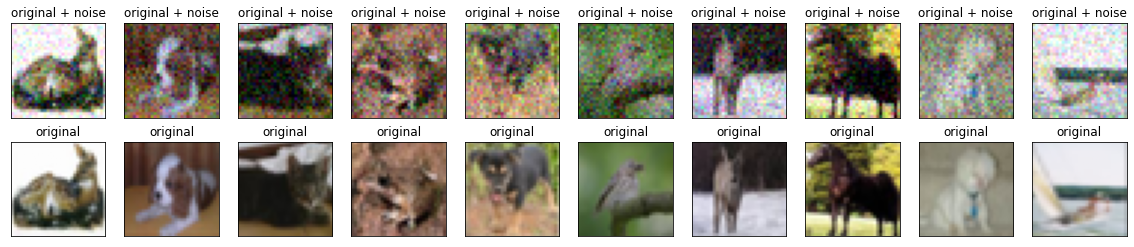

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for noise_images, images in train_dataset.take(1):

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(noise_images[i]))  # plot the noisy images
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        bx = plt.subplot(2, n, n + i + 1)
        plt.title("original")
        plt.imshow(tf.squeeze(images[i]))  # plot  images without noise
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)


plt.show()

# Create the Autoencoders Model

In [ ]:
# Create conv2d with batch normalization and relu activation block
class Conv2D_with_BN(tf.keras.layers.Layer):
    def __init__(self,filters,kernel_size,padding):
        super(Conv2D_with_BN,self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,padding=padding,use_bias=False)
        self.bh_norm = tf.keras.layers.BatchNormalization()
    def call(self,x):
        x = self.conv(x)
        x = self.bh_norm(x)
        x = tf.nn.relu(x)
        return x


## Encoder 
Here, we define the encoder network, which takes an input of size [None, 32, 32, 3]. There are five Conv blocks, each consisting of a Conv2D, BatchNorm and LeakyReLU activation function. at the second Conv and fourth Conv the image is down sampled by a factor of two.

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = Conv2D_with_BN(32,3,'same')
        self.conv2 = Conv2D_with_BN(64,3,'same')
        self.maxpool_1 = tf.keras.layers.MaxPool2D()
        self.conv3 = Conv2D_with_BN(128,3,'same')
        self.conv4 = Conv2D_with_BN(256,3,'same')
        self.maxpool_2 = tf.keras.layers.MaxPool2D()
        self.conv5 = Conv2D_with_BN(512,3,'same')
        self.out = Conv2D_with_BN(512,1,'valid')


    def call(self,x): 
        x =  self.conv1(x)
        x =  self.conv2(x)
        x =  self.maxpool_1(x)

        x =  self.conv3(x)
        x =  self.conv4(x)
        x =  self.maxpool_2(x)

        x =  self.conv5(x)

        x =  self.out(x)
        

        return x 

In [ ]:
encoder = Encoder()
encoder.build([None,32,32,3])

In [ ]:
encoder(noise_images[:2])

<tf.Tensor: shape=(2, 8, 8, 512), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.76004316e-02, 0.00000000e+00, 1.25173957e-03],
         [0.00000000e+00, 5.59811713e-03, 0.00000000e+00, ...,
          2.96761822e-02, 0.00000000e+00, 9.40029509e-03],
         [0.00000000e+00, 4.19007707e-03, 0.00000000e+00, ...,
          4.13042158e-02, 0.00000000e+00, 1.87589508e-03],
         ...,
         [0.00000000e+00, 1.02089690e-02, 0.00000000e+00, ...,
          4.49645892e-02, 0.00000000e+00, 1.35669792e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.68529446e-02, 0.00000000e+00, 1.61567423e-02],
         [1.46440305e-02, 0.00000000e+00, 0.00000000e+00, ...,
          2.56071296e-02, 0.00000000e+00, 1.48059046e-02]],

        [[0.00000000e+00, 0.00000000e+00, 6.30318606e-03, ...,
          3.32178921e-02, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 6.24091923e-03, 0.00000000e+00, ...,
          3

## Decoder
At the Decoder we are using special Convolution layer called Conv2DTranspose .

**[Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)** is a convolution operation whose kernel is learnt (just like normal conv2d operation) while training your model. Using Conv2DTranspose will also upsample  its input by using nearest neighbour or bilinear upsampling, but the key difference from the Conv2D is the model should learn what is the best upsampling for the job.  


The decoder network takes an input of size [None,8,8,512].

The initial block has a Conv2DTranspose layer having 512 filters. 

Recall that this was the size of the output in the encoder function .

There are a total of 10 Conv blocks. The Conv block [1, 5] consists of a Conv2DTranspose, BatchNorm and LeakyReLU activation function.

The Conv block 10 has a Conv2D  that has (1,1) kernel size with sigmoid activation function, which flattens  the output to be in the range [0, 1].

 In each block, the image is up sampled by a factor of two at block conv2T_1 and conv2T_2 .

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1 = Conv2D_with_BN(512,1,'valid')
        self.conv2 = Conv2D_with_BN(512,3,'same')
        self.conv2T_1 =tf.keras.layers.Conv2DTranspose(512,kernel_size=(2,2),strides=(2,2)) 
        self.conv3 = Conv2D_with_BN(256,1,'valid')

        self.conv4 = Conv2D_with_BN(256,3,'same')
        self.conv5 = Conv2D_with_BN(128,1,'valid')
        self.conv6 = Conv2D_with_BN(128,3,'same')
        self.conv2T_2 =tf.keras.layers.Conv2DTranspose(128,kernel_size=(2,2),strides=(2,2)) 
        self.conv7 = Conv2D_with_BN(64,1,'valid')
        self.conv8 = Conv2D_with_BN(64,3,'same')
        self.conv9 = Conv2D_with_BN(32,1,'valid')
        self.conv10 = Conv2D_with_BN(32,3,'same')
        self.out = tf.keras.layers.Conv2D(filters=3,kernel_size=1)




    def call(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv2T_1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv2T_2(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.out(x)
        x = tf.nn.sigmoid(x)


        return x 


# Let's See What the Model See

In [ ]:
# instantiate the decoder
decoder = Decoder()
decoder.build([None,8,8,512])

In [ ]:
# make a prediction 
test = decoder(encoder(noise_images[:2]))

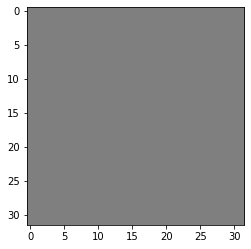

In [ ]:
# show what we predicted will look like before training
plt.imshow(test[0])

# Create the model


In [ ]:
# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Input([32,32,3]),
    Encoder(),
    Decoder()
])

In [ ]:
model.predict(noise_images[:2]).shape

(2, 32, 32, 3)

In [ ]:
# complete the model
model.compile(optimizer='adam',loss='mse')



In [ ]:
# Train the model
model.fit(train_dataset,epochs=100,validation_data=test_dataset)

# Let's see what the model sees After Training

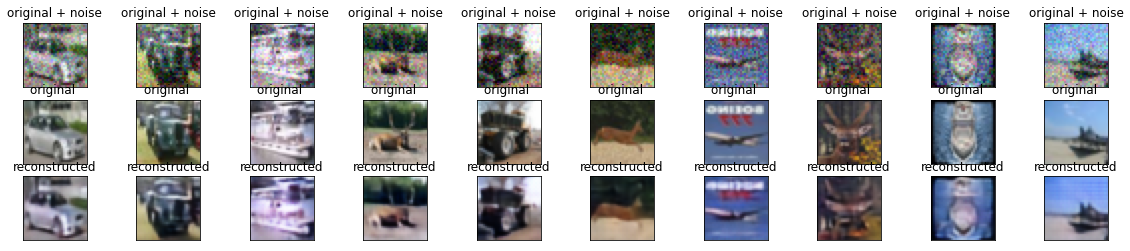

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for noisy_images, images in test_dataset.take(1):
    pred = model(noisy_images, training=False)  # make prediction
    for i in range(n):

        # display original + noise
        ax = plt.subplot(3, n, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(noisy_images[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display original
        ax = plt.subplot(3, n, n+i + 1)
        plt.title("original ")
        plt.imshow(tf.squeeze(images[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(3, n, i + n*2 + 1)
        plt.title("reconstructed")
        plt.imshow(tf.squeeze(pred[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
plt.show()